# Load Library

In [1]:
!pip install torch transformers datasets scikit-learn tqdm peft bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.0 MB/s eta 0:00:00


In [2]:
!pip install -U datasets huggingface-hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    T5EncoderModel,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
import bitsandbytes as bnb

In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Dataset Loader

In [5]:
dataset = load_dataset("fancyzhx/amazon_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [6]:
class AmazonPolarityDataset(Dataset):
  def __init__(self, data, tokenizer, max_length=256):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]
    text = item['content']

    encoding = self.tokenizer(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding='max_length',
      truncation=True,
      return_tensors='pt'
    )

    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(item['label'], dtype=torch.long)
    }

In [7]:
# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
print("Tokenizer loaded")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenizer loaded


In [8]:
# Create data subsets (using smaller subsets for faster training)
train_subset = dataset['train'].select(range(100000))  # Use 100k samples
test_subset = dataset['test'].select(range(20000))    # Use 20k samples
print(f"Training on {len(train_subset)} samples, testing on {len(test_subset)} samples")

# Create datasets
train_dataset = AmazonPolarityDataset(train_subset, tokenizer)
test_dataset = AmazonPolarityDataset(test_subset, tokenizer)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)
print("Dataloaders created")

Training on 100000 samples, testing on 20000 samples
Dataloaders created


### Model

In [9]:
# Define the QLoRA T5 classifier
class T5ClassifierWithQLoRA(nn.Module):
    def __init__(self, model_name='t5-small', num_classes=2):
        super().__init__()

        # Load T5 encoder model with 8-bit quantization for QLoRA
        self.t5 = T5EncoderModel.from_pretrained(
            model_name,
            load_in_8bit=True,
            device_map="auto"
        )

        # Prepare the model for QLoRA training
        self.t5 = prepare_model_for_kbit_training(self.t5)

        # Configure LoRA
        peft_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            inference_mode=False,
            r=16,  # Rank of the low-rank matrices (increased from 8)
            lora_alpha=32,  # Scaling factor
            lora_dropout=0.1,  # Dropout for LoRA layers
            target_modules=["q", "v"],  # Target attention modules
        )

        # Apply LoRA to the model
        self.t5 = get_peft_model(self.t5, peft_config)

        # Classification head
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.t5.config.d_model, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.logsm = nn.LogSoftmax(dim=1)

        # Print trainable parameters
        self.t5.print_trainable_parameters()

    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask)

        # Get the last hidden states
        last_hidden_states = outputs.last_hidden_state

        # Apply mean pooling (taking the mean of all tokens)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_pooled = sum_embeddings / sum_mask

        # Pass through classifier
        x = self.dropout(mean_pooled)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.logsm(x)

In [10]:
# Initialize the model
model = T5ClassifierWithQLoRA()
model.to(device)
print("Model initialized and moved to device")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

trainable params: 196,608 || all params: 35,527,424 || trainable%: 0.5534
Model initialized and moved to device


In [11]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = nn.NLLLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

In [12]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.NLLLoss()(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, predictions, actual_labels

In [13]:
# Set up optimizer and scheduler
num_epochs = 5
learning_rate = 2e-4  # Slightly lower learning rate for QLoRA

# Only optimize the trainable parameters (LoRA weights)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
print("Optimizer and scheduler configured")

Optimizer and scheduler configured


In [14]:
# Plotting function for training metrics
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting functions
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

Starting training...

Epoch 1/5


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 t

Train Loss: 0.3148, Train Acc: 0.8552
Val Loss: 0.2158, Val Acc: 0.9156
New best model saved with validation accuracy: 0.9156

Epoch 2/5


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 t

Train Loss: 0.2194, Train Acc: 0.9128
Val Loss: 0.2030, Val Acc: 0.9227
New best model saved with validation accuracy: 0.9227

Epoch 3/5


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 t

Train Loss: 0.2058, Train Acc: 0.9184
Val Loss: 0.2017, Val Acc: 0.9248
New best model saved with validation accuracy: 0.9248

Epoch 4/5


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 t

Train Loss: 0.1962, Train Acc: 0.9225
Val Loss: 0.2016, Val Acc: 0.9258
New best model saved with validation accuracy: 0.9258

Epoch 5/5


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 t

Train Loss: 0.1913, Train Acc: 0.9244
Val Loss: 0.1989, Val Acc: 0.9274
New best model saved with validation accuracy: 0.9274


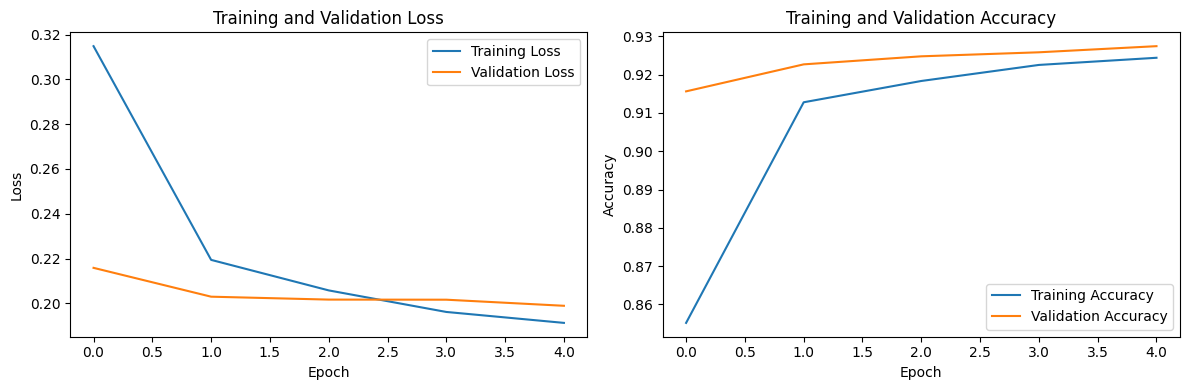

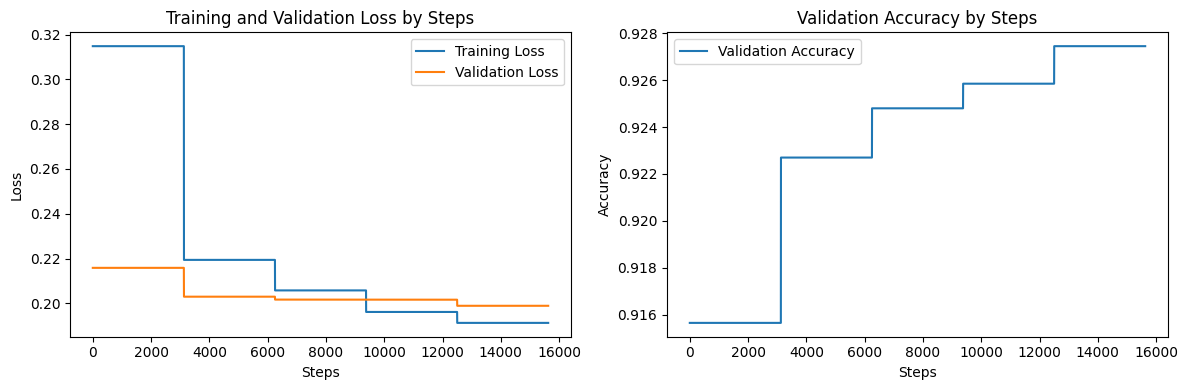

Loading best model and performing final evaluation...


RuntimeError: Loading a quantized checkpoint into non-quantized Linear8bitLt is not supported. Please call module.cuda() before module.load_state_dict()

In [15]:
# Training loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

# Store metrics for each step to plot detailed learning curves
step_train_losses = []
step_val_losses = []
step_val_accs = []
steps_per_epoch = len(train_dataloader)

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc, predictions, actuals = evaluate(model, test_dataloader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Store step-level metrics for plotting detailed curves
    for i in range(steps_per_epoch):
        step = epoch * steps_per_epoch + i
        step_train_losses.append(train_loss)  # Use epoch average as approximation
        step_val_losses.append(val_loss)
        step_val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_qlora_t5_model.pth')
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")

# Plot training history by epoch
plot_training_history(train_losses, train_accs, val_losses, val_accs)

# Plot detailed step-by-step training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(step_train_losses, label='Training Loss')
plt.plot(step_val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss by Steps')

plt.subplot(1, 2, 2)
plt.plot(step_val_accs, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy by Steps')

plt.tight_layout()
plt.savefig('training_history_by_steps.png')
plt.show()

Loading best model and performing final evaluation...


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating: 100%|██████████| 625/625 [01:27<00:00,  7.12it/s]



Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      9786
    Positive       0.93      0.92      0.93     10214

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



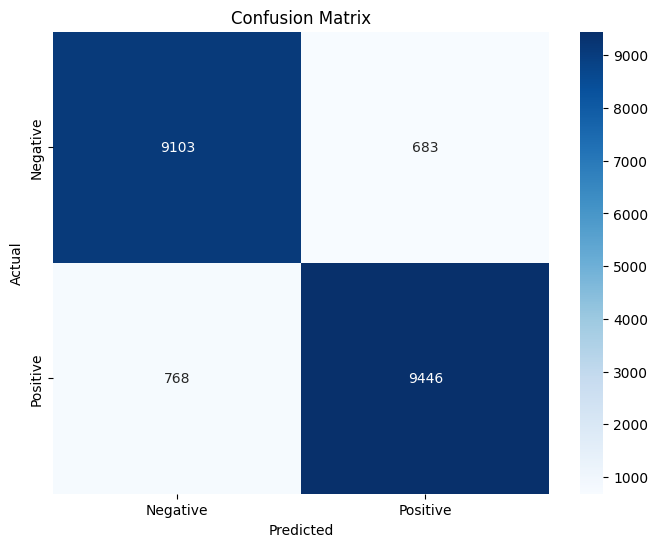

In [17]:
print("Loading best model and performing final evaluation...")
# Ensure the model is on the correct device BEFORE loading the state dict
model.cuda()
model.load_state_dict(torch.load('best_qlora_t5_model.pth')) # Add map_location for safety
_, _, predictions, actuals = evaluate(model, test_dataloader, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(actuals, predictions, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(actuals, predictions, ['Negative', 'Positive'])